# Data Science Challenge

In [121]:
# If additional packages are needed that are not installed by default, uncomment the last two lines of this 
# cell and replace <package list> with a list of additional packages.
# This will ensure the notebook has all the dependencies and works everywhere

import sys
#!{sys.executable} -m pip install <package list>
!pip install lightgbm
!pip install xgboost
!pip install -U seaborn
!pip install missingpy

Requirement already up-to-date: seaborn in /opt/conda/lib/python3.7/site-packages (0.11.2)
     |████████████████████████████████| 49 kB 3.1 MB/s eta 0:00:011


In [122]:
#Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option("display.max_columns", 101)


from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, Ridge
from sklearn.base import BaseEstimator, TransformerMixin
from missingpy import MissForest

from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import FunctionTransformer

from sklearn.decomposition import PCA

from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, StratifiedKFold, train_test_split, cross_validate

from sklearn.metrics import mean_squared_error

## Data Description

Column | Description
:---|:---
`id` | Record index
`timestamp` | Datetime (YYYY:MM:DD HH AM/PM)
`season` | Season (spring, summer, fall, winter)
`holiday` | Whether day is a holiday or not (Yes or No)
`workingday` | Whether day is a working day or not (Yes or No)
`weather`| Weather condition (Clear or partly cloudy, Mist, Light snow or rain, heavy rain/ice pellets/ snow + fog 
`temp`| Average temperature recorded for the hour ( in degree Celsius)
`temp_feel`| Average feeling temperature recorded for the hour ( in degree Celsius)
`hum`| Average humidity recorded for the hour (in %)
`windspeed`| Average wind speed recorded for the hour (in miles/hour)
`demand`| Hourly count of bikes rented

## Data Wrangling & Visualization

In [124]:
# The dataset is already loaded below
data = pd.read_csv("train.csv")
#Loading Test data
test_data=pd.read_csv('test.csv')

target = data['demand']

#all_data = data.concat([data.drop(columns=['demand']), test_data])
#all_data
(data.shape, test_data.shape)

((8708, 11), (1792, 10))

In [9]:
data.head()

,id,timestamp,season,holiday,workingday,weather,temp,temp_feel,humidity,windspeed,demand
0,1,2017-01-01 00:00:00,spring,No,No,Clear or partly cloudy,9.84,14.395,81.0,0.0,2.772589
1,2,2017-01-01 01:00:00,spring,No,No,Clear or partly cloudy,9.02,13.635,80.0,0.0,3.688879
2,3,2017-01-01 02:00:00,spring,No,No,Clear or partly cloudy,9.02,13.635,80.0,0.0,3.465736
3,4,2017-01-01 03:00:00,spring,No,No,Clear or partly cloudy,9.84,14.395,75.0,0.0,2.564949
4,5,2017-01-01 04:00:00,spring,No,No,Clear or partly cloudy,9.84,14.395,75.0,0.0,0.000000


In [69]:
test_data.head()

,id,timestamp,season,holiday,workingday,weather,temp,temp_feel,humidity,windspeed
0,8709,2018-08-05 05:00:00,fall,No,No,Clear or partly cloudy,29.52,34.850,74.0,16.9979
1,8710,2018-08-05 06:00:00,fall,No,No,Clear or partly cloudy,29.52,34.850,79.0,16.9979
2,8712,2018-08-05 08:00:00,fall,No,No,Clear or partly cloudy,31.16,36.365,66.0,22.0028
3,8713,2018-08-05 09:00:00,fall,No,No,Clear or partly cloudy,32.80,38.635,59.0,23.9994
4,8714,2018-08-05 10:00:00,fall,No,No,Clear or partly cloudy,32.80,38.635,59.0,27.9993


In [10]:
#Explore columns
data.columns

Index(['id', 'timestamp', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'temp_feel', 'humidity', 'windspeed', 'demand'],
      dtype='object')

In [11]:
#Description
data.describe()

,id,temp,temp_feel,humidity,windspeed,demand
count,8708.000000,7506.000000,8606.000000,8669.00000,8508.000000,8708.000000
mean,4354.500000,20.089454,23.531261,60.99354,13.048589,4.452725
std,2513.927405,8.023304,8.737997,19.67989,8.311058,1.493963
min,1.000000,0.820000,0.760000,0.00000,0.000000,0.000000
25%,2177.750000,13.940000,15.910000,46.00000,7.001500,3.637586
50%,4354.500000,20.500000,24.240000,60.00000,12.998000,4.867534
75%,6531.250000,26.240000,31.060000,77.00000,19.001200,5.556828
max,8708.000000,41.000000,45.455000,100.00000,56.996900,6.792344


In [33]:
data.isna().sum(), test_data.isna().sum()

(id               0
 timestamp        0
 season           0
 holiday          0
 workingday       0
 weather          0
 temp          1202
 temp_feel      102
 humidity        39
 windspeed      200
 demand           0
 dtype: int64,
 id            0
 timestamp     0
 season        0
 holiday       0
 workingday    0
 weather       0
 temp          0
 temp_feel     0
 humidity      0
 windspeed     0
 dtype: int64)

We have some missing data in temp and temp_feel aswell as humidty and windspeed.
In test_data we don't have any missing data

### Let's see if the categorical data is distributed in the same way between train and test data

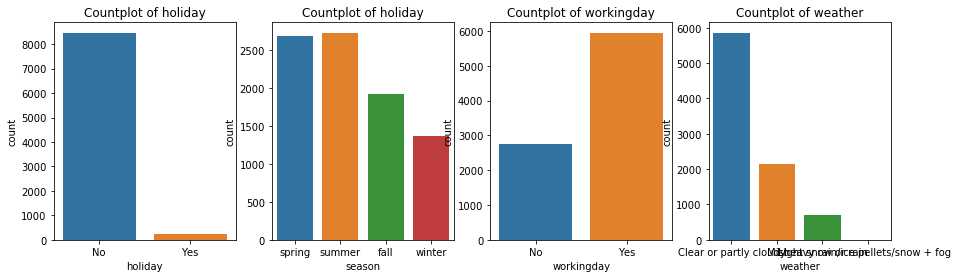

In [31]:
fig, ax = plt.subplots(1,4, figsize=(15,4))
sns.countplot(x="holiday", data=data, ax=ax[0])
ax[0].set_title('Countplot of holiday');
sns.countplot(x="season", data=data, ax=ax[1])
ax[1].set_title('Countplot of holiday');
sns.countplot(x="workingday", data=data, ax=ax[2])
ax[2].set_title('Countplot of workingday');
sns.countplot(x="weather", data=data, ax=ax[3])
ax[3].set_title('Countplot of weather');

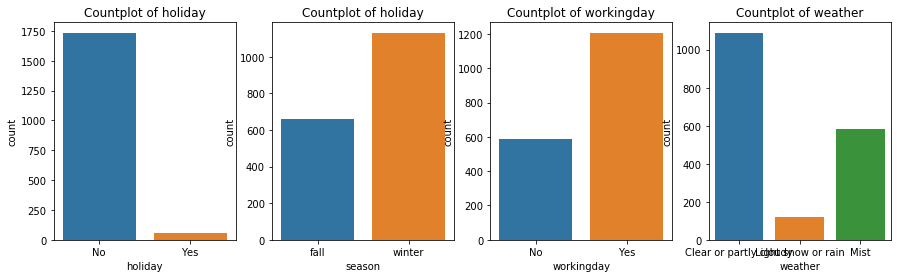

In [32]:
fig, ax = plt.subplots(1,4, figsize=(15,4))
sns.countplot(x="holiday", data=test_data, ax=ax[0])
ax[0].set_title('Countplot of holiday');
sns.countplot(x="season", data=test_data, ax=ax[1])
ax[1].set_title('Countplot of holiday');
sns.countplot(x="workingday", data=test_data, ax=ax[2])
ax[2].set_title('Countplot of workingday');
sns.countplot(x="weather", data=test_data, ax=ax[3])
ax[3].set_title('Countplot of weather');

### Let's look at the numerical data distribution

In [65]:
data["temp"] = data["temp"].fillna(-20);
data["temp_feel"] = data["temp_feel"].fillna(-20);
data["humidity"] = data["humidity"].fillna(-20);
data["windspeed"] = data["windspeed"].fillna(-20);

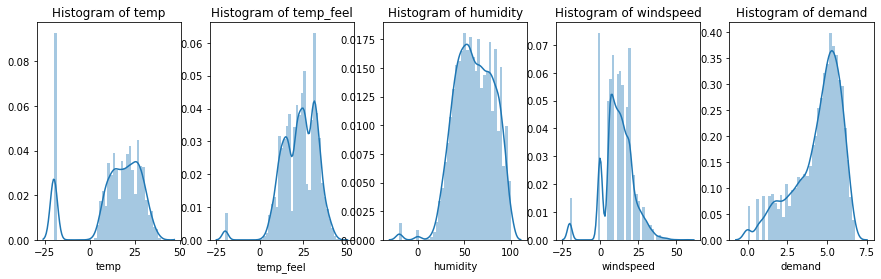

In [66]:
fig, ax = plt.subplots(1,5, figsize=(15,4))
sns.distplot(data["temp"], ax=ax[0])
ax[0].set_title('Histogram of temp');
sns.distplot(data["temp_feel"], ax=ax[1])
ax[1].set_title('Histogram of temp_feel');
sns.distplot(data["humidity"], ax=ax[2])
ax[2].set_title('Histogram of humidity');
sns.distplot(data["windspeed"], ax=ax[3])
ax[3].set_title('Histogram of windspeed');
sns.distplot(data["demand"], ax=ax[4])
ax[4].set_title('Histogram of demand');

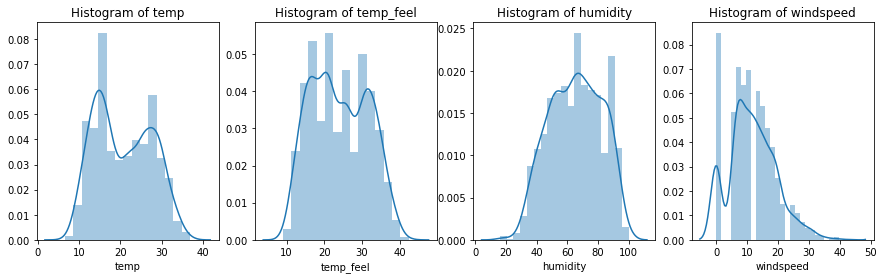

In [67]:
fig, ax = plt.subplots(1,4, figsize=(15,4))
sns.distplot(test_data["temp"], ax=ax[0])
ax[0].set_title('Histogram of temp');
sns.distplot(test_data["temp_feel"], ax=ax[1])
ax[1].set_title('Histogram of temp_feel');
sns.distplot(test_data["humidity"], ax=ax[2])
ax[2].set_title('Histogram of humidity');
sns.distplot(test_data["windspeed"], ax=ax[3])
ax[3].set_title('Histogram of windspeed');

### The distribution of numerical data looks somewhat similar

In [85]:
data["timestamp"].min(), data["timestamp"].max()

('2017-01-01 00:00:00', '2018-08-05 04:00:00')

In [86]:
test_data["timestamp"].min(), test_data["timestamp"].max()

('2018-08-05 05:00:00', '2018-12-19 23:00:00')

Test data has summer timestamp but no summer season.
We need to recalculate the season

## Feature engineering
- get month
- get day of the week
- get hour of the day
- log transform on demand

- recalculate season
- impute missing data
- apply OHE

In [199]:
# The dataset is already loaded below
data = pd.read_csv("train.csv")
test_data=pd.read_csv('test.csv')

y = np.log1p(np.ravel(np.array(data['demand']).T))
data = data.drop(columns=['demand'])

In [200]:
for df in [data, test_data]:
    df['date'] = pd.to_datetime(df['timestamp'], errors='coerce')
    df['day_of_week'] = df['date'].dt.day_name()
    df['month'] = df['date'].dt.month
    df['dayofyear'] = df['date'].dt.dayofyear
    df['hour'] = df['date'].dt.hour
 
    df["season"] = "winter"
    df.loc[df["dayofyear"] < 355, "season"] = "fall"
    df.loc[df["dayofyear"] < 264, "season"] = "summer"
    df.loc[df["dayofyear"] < 172, "season"] = "spring"  
    
    #Droping features
    df.drop(columns=['date', 'timestamp', 'id', 'dayofyear'], inplace=True)
    df[['month', 'hour']] = df[['month', 'hour']].astype(str)


In [201]:
#OneHotEncoding
class DataFrameOneHotEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, drop=None, handle_unknown="error"):
        #we give the choice to the user to drop columns and how to 
        #handle errors, the rest of the OHE parameters are hard coded
        #or by default
        self.drop = drop
        self.dtype = np.float64
        self.handle_unknown = handle_unknown
    
    def fit(self, X, y=None):
        #one OHE object per column is stored in this variable
        self.onehotencoders_ = []
        #variable that keep track of the names
        self.col_names = []
        cols = X.select_dtypes(include=["object", "category"]).columns
        for c in cols:
            #Now create, fit, and store the OHE for every column
            ohe = OneHotEncoder(sparse=False, drop=self.drop,
                                dtype=self.dtype,        
                                handle_unknown=self.handle_unknown)
            self.onehotencoders_.append(ohe.fit(X.loc[:, [c]]))
            #Get the feature names and remove each x0_
            col_names = ohe.get_feature_names()
            col_names = [x.replace("x0_", "") for x in col_names]
            #write the original column name before the new name
            col_names = [f"{c}_{x}" for x in col_names]
            self.col_names.append(col_names)
        return self
    
    def transform(self, X):
        all_df = []
        cols = X.select_dtypes(include=["object", "category"]).columns

        for i, c in enumerate(cols):
            ohe = self.onehotencoders_[i]
            ohe_col = ohe.transform(X.loc[:, [c]])
            df_col = pd.DataFrame(ohe_col, columns=self.col_names[i])
            all_df.append(df_col)

        OHE_df = pd.concat(all_df, axis=1)
        num_df = X.select_dtypes(exclude=["object", "category"])
        return pd.concat([num_df, OHE_df], axis=1)

## Apply OneHotEncoder to get the columns names

In [202]:
pipeline = Pipeline([
    ('encoding' , DataFrameOneHotEncoder(handle_unknown="ignore")),
    #('imputer' , MissForest()),
])
pipeline.fit(data)
data_preprocessed = pipeline.transform(data)

cols = data_preprocessed.columns.to_list()

## Apply now also the imputer and create a dataframe with the names of the columns

In [203]:
pipeline = Pipeline([
    ('encoding' , DataFrameOneHotEncoder(handle_unknown="ignore")),
    ('imputer' , MissForest()),
])
pipeline.fit(data)
data_preprocessed = pipeline.transform(data)
test_data_preprocessed = pipeline.transform(test_data)

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4


/opt/conda/lib/python3.7/site-packages/missingpy/missforest.py:528: UserWarning: No missing value located; returning original dataset.
  warnings.warn("No missing value located; returning original "


In [ ]:
data_preprocessed = pd.DataFrame(data_preprocessed, columns = cols)
test_data_preprocessed = pd.DataFrame(test_data_preprocessed, columns = cols)
data_preprocessed.head()

,temp,temp_feel,humidity,windspeed,season_fall,season_spring,season_summer,holiday_No,holiday_Yes,workingday_No,workingday_Yes,weather_Clear or partly cloudy,weather_Light snow or rain,weather_Mist,weather_heavy rain/ice pellets/snow + fog,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,month_1,month_10,month_11,month_12,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,hour_0,hour_1,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_2,hour_20,hour_21,hour_22,hour_23,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9
0,9.84,14.395,81.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,9.02,13.635,80.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,9.02,13.635,80.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,9.84,14.395,75.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,9.84,14.395,75.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
test_data_preprocessed.head()

,temp,temp_feel,humidity,windspeed,season_fall,season_spring,season_summer,holiday_No,holiday_Yes,workingday_No,workingday_Yes,weather_Clear or partly cloudy,weather_Light snow or rain,weather_Mist,weather_heavy rain/ice pellets/snow + fog,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,month_1,month_10,month_11,month_12,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,hour_0,hour_1,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_2,hour_20,hour_21,hour_22,hour_23,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9
0,29.52,34.850,74.0,16.9979,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,29.52,34.850,79.0,16.9979,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,31.16,36.365,66.0,22.0028,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,32.80,38.635,59.0,23.9994,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,32.80,38.635,59.0,27.9993,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
data_preprocessed

,temp,temp_feel,humidity,windspeed,season_fall,season_spring,season_summer,holiday_No,holiday_Yes,workingday_No,workingday_Yes,weather_Clear or partly cloudy,weather_Light snow or rain,weather_Mist,weather_heavy rain/ice pellets/snow + fog,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,month_1,month_10,month_11,month_12,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,hour_0,hour_1,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_2,hour_20,hour_21,hour_22,hour_23,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9
0,9.84,14.395,81.0,0.0000,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,9.02,13.635,80.0,0.0000,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,9.02,13.635,80.0,0.0000,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,9.84,14.395,75.0,0.0000,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,9.84,14.395,75.0,0.0000,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8703,30.34,34.850,70.0,19.0012,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8704,30.34,34.850,70.0,16.9979,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8705,30.34,34.850,70.0,19.9995,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8706,29.52,34.850,74.0,16.9979,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


## Visualization, Modeling, Machine Learning

Build a model that can predict hourly demand and identify how different features influence the decision. Please explain the findings effectively to technical and non-technical audiences using comments and visualizations, if appropriate.
- **Build an optimized model that effectively solves the business problem.**
- **The model will be evaluated on the basis of mean absolute error.**
- **Read the test.csv file and prepare features for testing.**

In [242]:
models_list = {'Ridge': Ridge(),
               #'DecisionTree Regressor': DecisionTreeRegressor(),
               'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=6), 
               #'SVR': SVR(gamma='auto'), 
               #'LGBMRegressor' :LGBMRegressor(verbosity = 0, force_row_wise=True), 
               #'XGBRegressor': XGBRegressor(learning_rate=0.008, n_estimators=6000, max_depth=4, min_child_weight=0, gamma=0.6, subsample=0.7, colsample_bytree=0.7,
               #        objective='reg:squarederror', nthread=-1, scale_pos_weight=1, seed=27, reg_alpha=0.00006, use_label_encoder=False, verbosity = 0), 
               'Lasso': Lasso(alpha=0.0005),
               #'KernelRidge': KernelRidge(),
               'ElasticNet': ElasticNet(alpha=0.0006, l1_ratio=1),
               'BayesianRidge': BayesianRidge(),
               'GradientBoostingRegressor': GradientBoostingRegressor()
              }

folds = KFold(n_splits=5, shuffle=True, random_state=0)

In [243]:
scoring = {'MAE':'neg_mean_absolute_error'}
columns = ['Model', 'Median fit time', 'mean MEA', 'Std MEA']

In [244]:
x = data_preprocessed.to_numpy()

model_perf_matrix = []
predictions = pd.DataFrame()

for model_name, model in models_list.items():
    pipeline = Pipeline([
        ('model' , model)
    ])

    cv_score = cross_validate(pipeline, x, y, cv=folds, scoring=scoring, 
                              verbose=0, error_score="raise");
    model_perf_matrix.append([model_name, round(cv_score['fit_time'].mean(),3),
                              round(cv_score['test_MAE'].mean(),4), round(cv_score['test_MAE'].std(),4)])
    
    pipeline.fit(x,y)
    predictions[model_name] = np.expm1(pipeline.predict(test_data_preprocessed.to_numpy())).T
    print(model_name)
    
df_model_perf = pd.DataFrame(model_perf_matrix, columns=columns)
df_model_perf

Ridge
Random Forest
Lasso
ElasticNet
BayesianRidge
GradientBoostingRegressor


,Model,Median fit time,mean MEA,Std MEA
0,Ridge,0.013,-0.1201,0.0030
1,Random Forest,1.428,-0.1314,0.0022
2,Lasso,0.689,-0.1199,0.0030
3,ElasticNet,0.379,-0.1200,0.0030
4,BayesianRidge,0.101,-0.1201,0.0030
5,GradientBoostingRegressor,0.971,-0.0943,0.0025


### We can aggregate the models to probably have a better prediction

In [250]:
predictions['avr'] = predictions['Ridge']*0.1 + predictions['Lasso']*0.2 + predictions['ElasticNet']*0.1 + predictions['BayesianRidge']*0.1 + predictions['GradientBoostingRegressor']*0.5
predictions.head(20)

,Ridge,Random Forest,Lasso,ElasticNet,BayesianRidge,GradientBoostingRegressor,avr
0,2.922530,2.087772,2.991346,3.005609,2.921673,2.465543,2.716022
1,4.305013,5.289304,4.393376,4.411124,4.304724,3.402777,3.882150
2,6.390980,5.289304,6.377626,6.371985,6.391351,5.309268,5.845591
3,6.204020,5.289304,6.203255,6.199775,6.204067,5.536777,5.869826
4,5.777989,5.289304,5.875260,5.886211,5.778039,5.481515,5.660033
5,5.919839,5.289304,5.940743,5.954676,5.919978,5.481515,5.708355
6,6.130442,5.289304,6.140916,6.139286,6.130337,5.552518,5.844449
7,6.168804,5.289304,6.178836,6.177132,6.168714,5.552518,5.863491
8,6.162509,5.289304,6.203596,6.231010,6.162346,5.552518,5.872565
9,6.105050,5.289304,6.136387,6.144850,6.104745,5.552518,5.839001


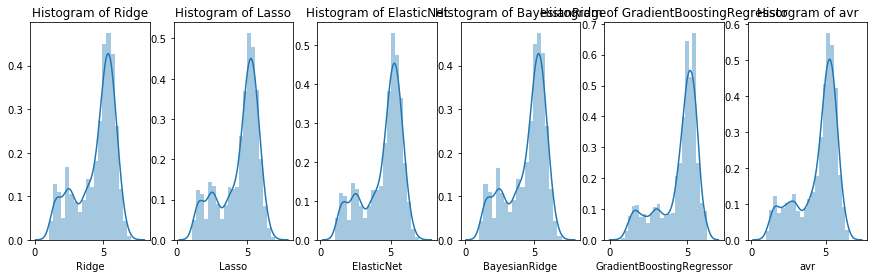

In [252]:
fig, ax = plt.subplots(1,6, figsize=(15,4))
sns.distplot(predictions["Ridge"], ax=ax[0])
ax[0].set_title('Histogram of Ridge');
sns.distplot(predictions["Lasso"], ax=ax[1])
ax[1].set_title('Histogram of Lasso');
sns.distplot(predictions["ElasticNet"], ax=ax[2])
ax[2].set_title('Histogram of ElasticNet');
sns.distplot(predictions["BayesianRidge"], ax=ax[3])
ax[3].set_title('Histogram of BayesianRidge');
sns.distplot(predictions["GradientBoostingRegressor"], ax=ax[4])
ax[4].set_title('Histogram of GradientBoostingRegressor');
sns.distplot(predictions["avr"], ax=ax[5])
ax[5].set_title('Histogram of avr');



**Identify the most important features of the model for management.**

> #### Task:
- **Visualize the top 20 features and their feature importance.**


Index(['month_1', 'hour_22', 'month_2', 'humidity', 'season_fall', 'hour_16',
       'weather_Light snow or rain', 'hour_9', 'temp', 'hour_19', 'temp_feel',
       'season_spring', 'hour_8', 'hour_7', 'hour_17', 'hour_23', 'hour_18',
       'hour_6', 'workingday_No', 'hour_0', 'hour_5', 'hour_2', 'hour_1',
       'hour_3', 'hour_4'],
      dtype='object')


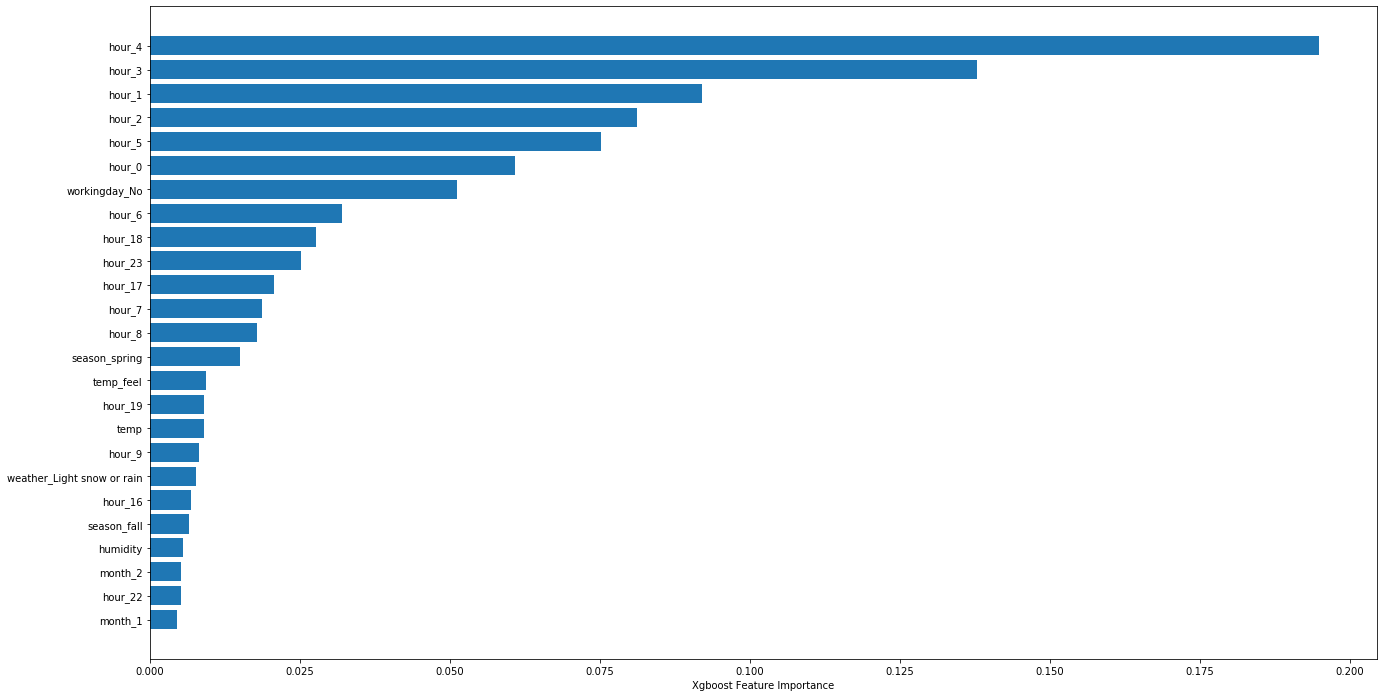

In [210]:
xgb = XGBRegressor(n_estimators=200)
xgb.fit(data_preprocessed, y)
xgb.feature_importances_

sorted_idx = xgb.feature_importances_.argsort()[-20:]
xgb.feature_importances_[sorted_idx]
xgb.feature_importances_[sorted_idx]

fig, ax = plt.subplots(1,1, figsize=(22,12))
ax = plt.barh(data_preprocessed.columns[sorted_idx].map(str), xgb.feature_importances_[sorted_idx])
ax = plt.xlabel("Xgboost Feature Importance")

print(data_preprocessed.columns[sorted_idx])

> #### Task:
- **Submit the predictions on the test dataset using the optimized model** <br/>
    For each record in the test set (`test.csv`), predict the value of the `demand` variable. Submit a CSV file with a header row and one row per test entry.
    
The file (`submissions.csv`) should have exactly 2 columns:
   - **id**
   - **demand**

In [254]:
submission_df = pd.DataFrame({'Id': pd.read_csv('test.csv').id, 'demand': predictions['avr']})

In [255]:
submission_df

,Id,demand
0,8709,2.716022
1,8710,3.882150
2,8712,5.845591
3,8713,5.869826
4,8714,5.660033
...,...,...
1787,10882,5.274109
1788,10883,4.948639
1789,10884,4.820013
1790,10885,4.739717


In [256]:
#Submission
submission_df.to_csv('submissions.csv',index=False)

---